In [64]:
# Extract Tweet of a Specific person :

# https://fairyonice.github.io/extract-someones-tweet-using-tweepy.html

In [65]:
# 1. Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tweepy
from tweepy import OAuthHandler

import os
import dotenv

from dotenv import load_dotenv


In [66]:
# 2.Set Connecion
# Get from developers.twitter.com/App->Setting->keys&tokens
# Just assign the credentials

load_dotenv()  # take environment variables from .env.
config = dotenv.dotenv_values(".env")   # config = {"USER": "foo", "EMAIL": "foo@example.org"}
print(config)

# keys and tokens from the Twitter Dev Console
consumer_key = config.get('consumer_key')
consumer_secret = config.get('consumer_secret')
access_token = config.get('access_token')
access_token_secret = config.get('access_token_secret')

# Use the above credentials to authenticate the API.
auth = tweepy.OAuthHandler( consumer_key , consumer_secret )
auth.set_access_token( access_token , access_token_secret )
api = tweepy.API(auth)

OrderedDict([('consumer_key', 'TV44Dlk2DvpsQXoJVt3pmPdNR'), ('consumer_secret', 'OmVwO0JY3FxQbiDRTVvCHLYjbF2MMXXWOsjkRmoWC2rPZViZlp'), ('access_token', '29489350-tYWLX2Dv5U6CTQhErJoVcT27LJHCKyUdMgfnqIKY8'), ('access_token_secret', 'kAHNEG2hb8jf5cdEARemoEukZ9JgxiCuk5wB0vWCd56VX'), ('bearer_token', 'AAAAAAAAAAAAAAAAAAAAANpgRwEAAAAACkYaNPK1tUXgIaT5Yu0OKfuerUw%3DcobkuCKlIZGcS81eW4Lff2ftHFsLO6bjz3ttjwloX9Vj6O9uXz')])


In [67]:
# 3.To get the tweets in a Proper format, first lets create a Dataframe to store the extracted data.

df = pd.DataFrame(columns=["Date","User","IsVerified","Tweet","Likes","RT",'User_location'])
print(df)

Empty DataFrame
Columns: [Date, User, IsVerified, Tweet, Likes, RT, User_location]
Index: []


In [68]:
# We will use api as api.search inside this tweepy cursor.

In [69]:
# 4.Write a Function to extract tweets:

# We will Use **tweepy.cursor()** because we want to extract a larger number of tweets i.e over 100,500 etc


def get_tweets(Topic,Count):    
    i=0
    for tweet in tweepy.Cursor(api.search_tweets, q=Topic,count=100, lang="en",exclude='retweets').items():
        print(i, end='\r')
        # df.loc[i,"Date"] = tweet.created_at
        df.loc[i,"Date"] = pd.to_datetime(tweet.created_at).date()
        df.loc[i,"User"] = tweet.user.name
        df.loc[i,"IsVerified"] = tweet.user.verified
        df.loc[i,"Tweet"] = tweet.text
        df.loc[i,"Likes"] = tweet.favorite_count
        df.loc[i,"RT"] = tweet.retweet_count
        df.loc[i,"User_location"] = tweet.user.location
        #df.to_csv("TweetDataset.csv",index=False)
        # Adjust time zone from columns
        # df['Date'] = pd.to_datetime( df['Date'], errors='coerce',utc=True)
        # df.loc[i, 'Date'] = df.loc[i, 'Date'].dt.tz_localize(None)
        #c df.loc[i, 'Date'] = pd.to_datetime(df.loc[i, 'Date']).date()


        ## Save as Excel
        df.to_excel('{}.xlsx'.format("TweetDataset"),index=False)
        i=i+1
        if i>Count:
            break
        else:
            pass
        

In [70]:
# Call the function to extract the data. pass the topic and filename you want the data to be stored in.
Topic=["$TSLA"]
get_tweets(Topic , Count=400)

Unexpected parameter: exclude


Unexpected parameter: exclude


In [71]:
df.head(8)

,Date,User,IsVerified,Tweet,Likes,RT,User_location
0,2022-07-25,DipTrader,False,@elonmusk Please build more super chargers let...,0,0,
1,2022-07-25,Hitesh Rijhwani,False,@elonmusk Please don’t stop tweeting. You’re o...,0,0,Midwest USA
2,2022-07-25,SuperStickman,False,@elonmusk They want $TSLA to go 📉📉📉,0,0,
3,2022-07-25,nGiStrategy,False,$SPX it’s 5x💯 SP 500 Index\n\nWelcome to nGiSt...,0,0,"Dallas, TX"
4,2022-07-25,Billionaireclubcollc.com,False,How Much Does It Cost To Charge an EV on a Roa...,0,0,"New York, USA"
5,2022-07-25,TeslaHODL,False,@elonmusk Well said and done Elon.\nWe support...,0,0,
6,2022-07-25,Whole Mars Catalog,False,Today I was driving on the highway behind an S...,6,0,"San Francisco, CA"
7,2022-07-25,Trey,False,@elonmusk Pumping TSLA back to ATH benefits us...,0,0,"Jacksonville Beach, FL"


# Analyze the tweets

In [72]:
# Function to Clean the Tweet.

import re
def clean_tweet(tweet):
    return ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|([RT])', ' ', str(tweet).lower()).split())

# We only want the Text so :

# (@[A-Za-z0-9]+)   : Delete Anything like @hello @Letsupgrade etc
# ([^0-9A-Za-z \t]) : Delete everything other than text,number,space,tabspace
# (\w+:\/\/\S+)     : Delete https://
# ([RT]) : Remove "RT" from the tweet

In [73]:
# Funciton to analyze Sentiment

from textblob import TextBlob
def analyze_sentiment(tweet):
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'


In [74]:
#Function to Pre-process data for Worlcloud:here we are removing the words present in Topic from the Corpus so they dont come in WordCloud.
# Ex : Topic is "Arsenal vs United", we want to remove "Arsenal" "vs" "United" from the WordCloud.

def prepCloud(Topic_text,Topic):
    Topic = str(Topic).lower()
    Topic=' '.join(re.sub('([^0-9A-Za-z \t])', ' ', Topic).split())
    Topic = re.split("\s+",str(Topic))
    stopwords = set(STOPWORDS)
    stopwords.update(Topic) ### Add our topic in Stopwords, so it doesnt appear in wordClous
    ###
    text_new = " ".join([txt for txt in Topic_text.split() if txt not in stopwords])
    return text_new


In [75]:
# Call function to get Clean tweets

df['clean_tweet'] = df['Tweet'].apply(lambda x : clean_tweet(x))
df.head(5)

,Date,User,IsVerified,Tweet,Likes,RT,User_location,clean_tweet
0,2022-07-25,DipTrader,False,@elonmusk Please build more super chargers let...,0,0,,please build more super chargers lets gooo tsl...
1,2022-07-25,Hitesh Rijhwani,False,@elonmusk Please don’t stop tweeting. You’re o...,0,0,Midwest USA,please don t stop tweeting you re our source o...
2,2022-07-25,SuperStickman,False,@elonmusk They want $TSLA to go 📉📉📉,0,0,,they want tsla to go
3,2022-07-25,nGiStrategy,False,$SPX it’s 5x💯 SP 500 Index\n\nWelcome to nGiSt...,0,0,"Dallas, TX",spx it s 5x sp 500 index welcome to ngistrateg...
4,2022-07-25,Billionaireclubcollc.com,False,How Much Does It Cost To Charge an EV on a Roa...,0,0,"New York, USA",how much does it cost to charge an ev on a roa...


In [76]:
# Call function to get the Sentiments

df["Sentiment"] = df["Tweet"].apply(lambda x : analyze_sentiment(x))
df.head(5)

,Date,User,IsVerified,Tweet,Likes,RT,User_location,clean_tweet,Sentiment
0,2022-07-25,DipTrader,False,@elonmusk Please build more super chargers let...,0,0,,please build more super chargers lets gooo tsl...,Positive
1,2022-07-25,Hitesh Rijhwani,False,@elonmusk Please don’t stop tweeting. You’re o...,0,0,Midwest USA,please don t stop tweeting you re our source o...,Neutral
2,2022-07-25,SuperStickman,False,@elonmusk They want $TSLA to go 📉📉📉,0,0,,they want tsla to go,Neutral
3,2022-07-25,nGiStrategy,False,$SPX it’s 5x💯 SP 500 Index\n\nWelcome to nGiSt...,0,0,"Dallas, TX",spx it s 5x sp 500 index welcome to ngistrateg...,Positive
4,2022-07-25,Billionaireclubcollc.com,False,How Much Does It Cost To Charge an EV on a Roa...,0,0,"New York, USA",how much does it cost to charge an ev on a roa...,Positive


In [77]:
# Check Summary of Random Record
n = 15
print("Original tweet:\n",df['Tweet'][n])
print()
print("Clean tweet:\n",df['clean_tweet'][n])
print()
print("Sentiment of the tweet:\n",df['Sentiment'][n])

Original tweet:
 Caught a tiny $FAZE pump lol

--------------
$TSLA $SPY $AMC $RDBX $SIGA $GOVX $SPX $WMT $SNAP $AAPL $GME $XELA… https://t.co/vDDkdifiSP

Clean tweet:
 caught a tiny faze pump lol tsla spy amc rdbx siga govx spx wmt snap aapl gme xela

Sentiment of the tweet:
 Positive


In [78]:
# Overall Summary

print("Total Tweets Extracted for Topic : {} are : {}".format(Topic,len(df.Tweet)))
print("Total Positive Tweets are : {}".format(len(df[df["Sentiment"]=="Positive"])))
print("Total Negative Tweets are : {}".format(len(df[df["Sentiment"]=="Negative"])))
print("Total Neutral Tweets are : {}".format(len(df[df["Sentiment"]=="Neutral"])))

Total Tweets Extracted for Topic : ['$TSLA'] are : 101
Total Positive Tweets are : 37
Total Negative Tweets are : 17
Total Neutral Tweets are : 47


In [79]:
df["Sentiment"].value_counts()

Neutral     47
Positive    37
Negative    17
Name: Sentiment, dtype: int64

/Users/ravibyakod/.conda/envs/mec-5.3.10-data-wranging-with-pandas-mini-project/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Summary of Counts for Total tweets')

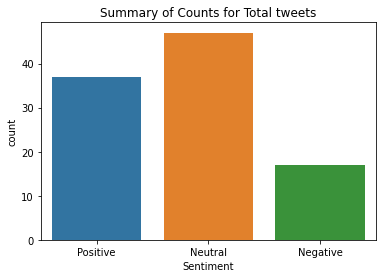

In [80]:
#sns.countplot(df["Sentiment"],facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))
sns.countplot(df["Sentiment"])
plt.title("Summary of Counts for Total tweets")


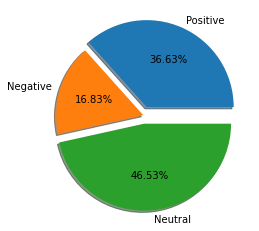

In [81]:
# Piechart 
#string, used to label the wedges with their numeric value. The label will be placed inside the wedge. The format string will be fmt%pct.

a=len(df[df["Sentiment"]=="Positive"])
b=len(df[df["Sentiment"]=="Negative"])
c=len(df[df["Sentiment"]=="Neutral"])
d=np.array([a,b,c])
explode = (0.1, 0.0, 0.1)
plt.pie(d,shadow=True,explode=explode,labels=["Positive","Negative","Neutral"],autopct='%1.2f%%');

/Users/ravibyakod/.conda/envs/mec-5.3.10-data-wranging-with-pandas-mini-project/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Summary of Counts for Total tweets,Distributed by if the User has a verified Account or not')

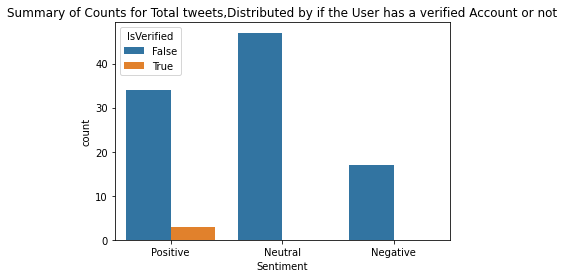

In [84]:
sns.countplot(df["Sentiment"],hue=df.IsVerified)
plt.title("Summary of Counts for Total tweets,Distributed by if the User has a verified Account or not")

# Generate WordCloud

In [85]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

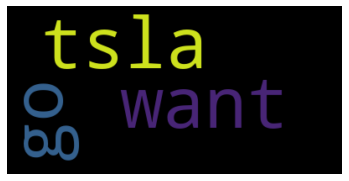

In [86]:
# Start with one review:

text = df.clean_tweet[2]

# Create and generate a word cloud image:
wordcloud = WordCloud(max_words=10).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- **WordCloud for whole data(Topic not included in WordCloud)**

There are 8230 words in the combination of all review.


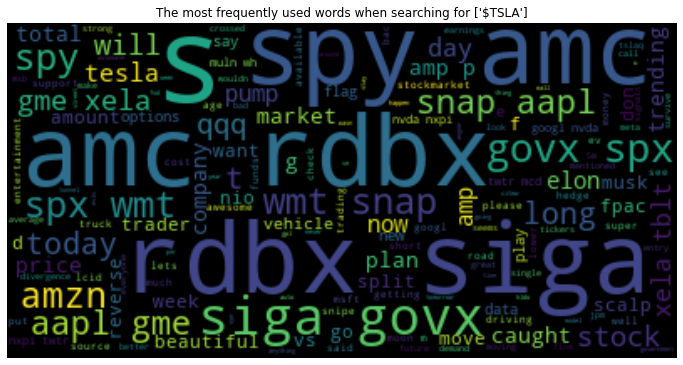

In [87]:
# Combine all reviews into one big text and create a Cloud to see which Words are most common in these Tweets.

text = " ".join(review for review in df.clean_tweet)
print ("There are {} words in the combination of all review.".format(len(text)))


# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["drink", "now", "wine", "flavor", "flavors"])  #To add any custom StopWords

text_newALL = prepCloud(text,Topic)


# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,max_words=800,max_font_size=70).generate(text_newALL)

# Display the generated image:
# the matplotlib way:


plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("The most frequently used words when searching for {}".format(Topic),)
plt.axis("off")
plt.show()

## NEW

- **Wordcloud for Positive tweets only (Topic not included in WordCloud)**

There are 8230 words in the combination of all review.


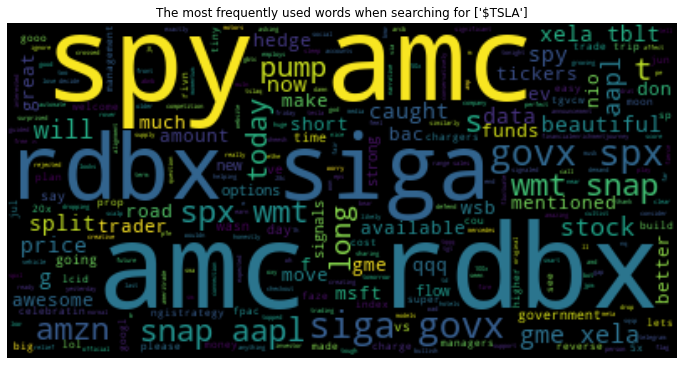

In [88]:
# Combine POSITIVE reviews into one big text and create a Cloud to see which Words are most common in these Tweets.

text_positive = " ".join(review for review in df[df["Sentiment"]=="Positive"].clean_tweet)
print ("There are {} words in the combination of all review.".format(len(text)))


# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["and", "now", "wine", "flavor", "flavors"])  #To add any custom StopWords
#text_positive=" ".join([word for word in text_positive.split() if word not in stopwords])

text_new_positive = prepCloud(text_positive,Topic)

#stopwords.update(["drink", "now", "wine", "flavor", "flavors"])  #To add any custom StopWords

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,max_words=800,max_font_size=70).generate(text_new_positive)

# Display the generated image:
# the matplotlib way:


plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("The most frequently used words when searching for {}".format(Topic))
plt.axis("off")
plt.show()

- **Wordcloud for Negative tweets only  (Topic not included in WordCloud)**

There are 8230 words in the combination of all review.


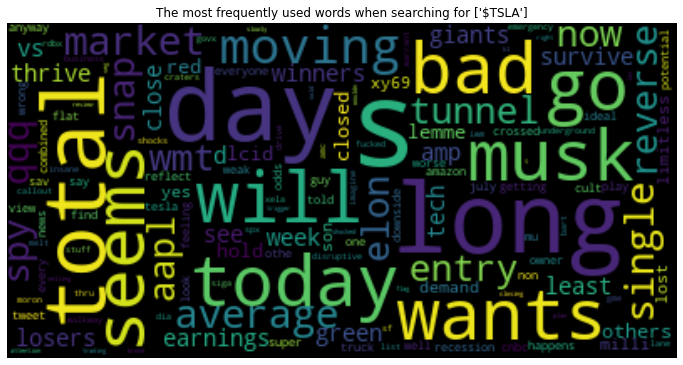

In [89]:
# Combine Negative reviews into one big text and create a Cloud to see which Words are most common in these Tweets.

text_negative = " ".join(review for review in df[df["Sentiment"]=="Negative"].clean_tweet)
print ("There are {} words in the combination of all review.".format(len(text)))


# Create stopword list:
stopwords = set(STOPWORDS)
#stopwords.update(["and", "now", "wine", "flavor", "flavors"])  #To add any custom StopWords

#text_negative=" ".join([word for word in text_negative.split() if word not in stopwords])
text_new_negative = prepCloud(text_negative,Topic)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords,max_words=800,max_font_size=70).generate(text_new_negative)

# Display the generated image:
# the matplotlib way:


plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("The most frequently used words when searching for {}".format(Topic))
plt.axis("off")
plt.show()

# Import image in streamlit.

import streamlit as st
from PIL import Image
import os
os.chdir("F:/Machine Learning/AI ML/Case Studies/Flask/TwitterFromScratch")
image = Image.open('Logo.jpg')
st.image(image, caption='Sunrise by the mountains',use_column_width=True)
st.pyplot()